In [12]:
#calculate position of SACCF - see paragraph 6: https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2001JC001227
#postion of 1.8C isotherm at 400 or 500m depth

In [37]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cartopy.crs as ccrs
import cmocean as cm
from collections import OrderedDict
import cftime
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
import matplotlib.path as mpath
import pickle

import cmocean.cm as cmocean
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [14]:
client = Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:45455 Dashboard: /proxy/45691/status,Cluster Workers: 8 Cores: 8 Memory: 100.00 GiB


In [15]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

from cosima_cookbook import explore
dbx = explore.DatabaseExplorer #(session=session)
dbx

ee = explore.ExperimentExplorer(session=session, experiment='01deg_jra55v140_iaf')
ee

In [16]:
#cc.querying.get_experiments(session)

In [17]:
import cartopy.feature as cft
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor='gray', linewidth=0.5)

In [18]:
expt='01deg_jra55v140_iaf'
variable='ht'
ht = cc.querying.getvar('01deg_jra55v140_iaf','ht',session,n=1).sel(yt_ocean=slice(-90,-55))
#ht = cc.querying.getvar(expt,variable,session, n=-1).fillna(1.0).astype(int) - 1
ht.load()
print(ht.shape)

variable='hu'
hu = cc.querying.getvar(expt,variable,session, n=-1).fillna(1.0).astype(int) - 1
hu.load()
print(hu.shape)

(584, 3600)
(2700, 3600)


In [19]:
expt='01deg_jra55v140_iaf'
variable='xt_ocean'
xt_ocean = cc.querying.getvar(expt,variable,session, n=-1).fillna(1.0).astype(int) - 1
xt_ocean.load()
print(xt_ocean.shape)

expt='01deg_jra55v140_iaf'
variable='yt_ocean'
yt_ocean = cc.querying.getvar(expt,variable,session, n=-1).fillna(1.0).astype(int) - 1
yt_ocean.load()
print(yt_ocean.shape)

variable='area_t'
area_t = cc.querying.getvar(expt,variable,session, n=-1).fillna(1.0).astype(int) - 1
area_t.load()
print(area_t.shape)

variable='xu_ocean'
xu_ocean = cc.querying.getvar(expt,variable,session, n=-1).fillna(1.0).astype(int) - 1
xu_ocean.load()
print(xu_ocean.values)

variable='yu_ocean'
yu_ocean = cc.querying.getvar(expt,variable,session, n=-1).fillna(1.0).astype(int) - 1
yu_ocean.load()
print(yu_ocean.shape)

variable='area_u'
area_u = cc.querying.getvar(expt,variable,session, n=-1).fillna(1.0).astype(int) - 1
area_u.load()
print(area_u.shape)

variable='st_ocean'
st_ocean = cc.querying.getvar(expt,variable,session, n=-1).fillna(1.0).astype(int) - 1
st_ocean.load()
print(st_ocean.shape)

(3600,)
(2700,)
(2700, 3600)
[-280 -280 -280 ...   78   78   79]
(2700,)
(2700, 3600)
(75,)


In [20]:
ltm_temp1=xr.open_dataset('/g/data/v45/pas561/jnb/ensoant/data/temp_01_cycle2_0501to0712.nc',engine='netcdf4',decode_times=False)
print(ltm_temp1.ltm_temp1.shape)

ltm_temp2=xr.open_dataset('/g/data/v45/pas561/jnb/ensoant/data/temp_01_cycle2_1501to1712.nc',engine='netcdf4',decode_times=False)
print(ltm_temp2.ltm_temp2.shape)



(75, 584, 3600)
(75, 584, 3600)


In [21]:
print(st_ocean[37])

<xarray.DataArray 'st_ocean' ()>
array(422)
Coordinates:
    st_ocean  float64 423.7


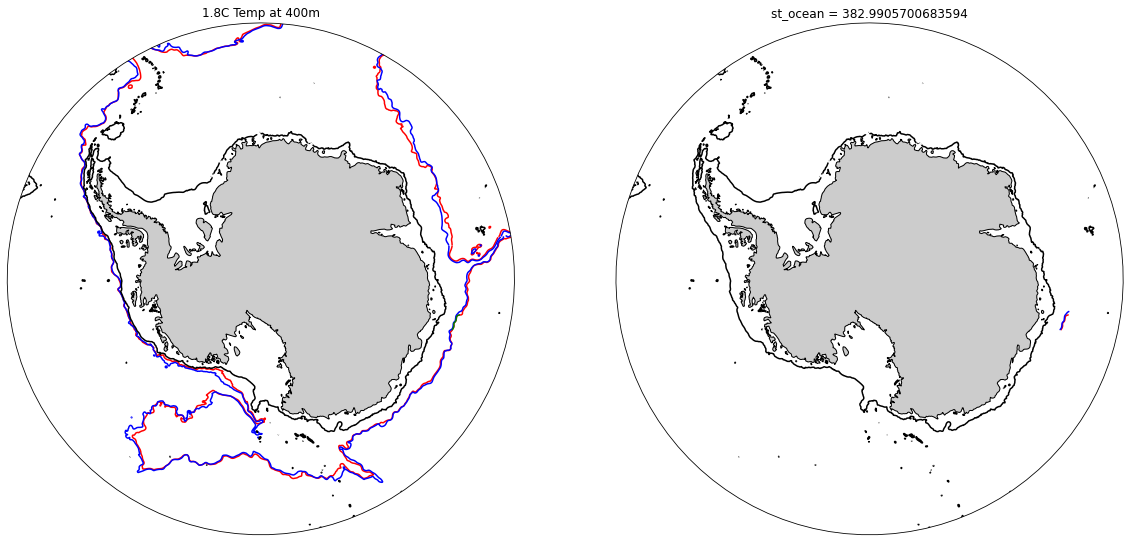

In [25]:
projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(20, 18))
#plt.suptitle('IAF Cycle 1, Big El Nino\'s Temp Anomaly at 200 m')

ax = plt.subplot(1, 2, 1, projection=projection)

ax.set_extent([-280, 80, -80, -55], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# isel(st_ocean=(37))

#p1 = ltm_temp1.ltm_temp1.sel(st_ocean=(400),method='nearest').plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin=271, vmax=278, add_colorbar=False, cmap=plt.cm.seismic, extend='both', transform=ccrs.PlateCarree())
p1 = ltm_temp1.ltm_temp1.sel(st_ocean=(400),method='nearest').plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=[274.95], colors='r',linewidth=1,
                       transform=ccrs.PlateCarree())
p2 = ltm_temp2.ltm_temp2.sel(st_ocean=(400),method='nearest').plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=[274.95], colors='b',linewidth=1,
                       transform=ccrs.PlateCarree())
p3 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=[1000], colors='k',linewidth=1,
#                       x='xt_ocean', y='yt_ocean', levels=2, vmin=999, vmax=1002, colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())

#mb_mask = ht.where(~xr.ufuncs.isfinite(ht.where((ht>1000) & (yt_ocean>-60) & (xt_ocean<-158) & (xt_ocean>-103) )))
p1a = ltm_temp1.ltm_temp1.sel(st_ocean=(400),method='nearest').sel(yt_ocean=slice(-90,-62)).sel(xt_ocean=slice(-265,-255)).plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=[274.95], colors='g',linewidth=1,
                       transform=ccrs.PlateCarree())

plt.title('1.8C Temp at 400m')

#ax_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
#cb = plt.colorbar(p1,cax=ax_cb, orientation='vertical', extend='both')
#cb.ax.set_xlabel('°C');

ax = plt.subplot(1, 2, 2, projection=projection)

ax.set_extent([-280, 80, -80, -55], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# isel(st_ocean=(37))

p3 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=[1000], colors='k',linewidth=1,
#                       x='xt_ocean', y='yt_ocean', levels=2, vmin=999, vmax=1002, colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())

#mb_mask = ht.where(~xr.ufuncs.isfinite(ht.where((ht>1000) & (yt_ocean>-60) & (xt_ocean<-158) & (xt_ocean>-103) )))
p1a = ltm_temp1.ltm_temp1.sel(st_ocean=(400),method='nearest').sel(yt_ocean=slice(-90,-62)).sel(xt_ocean=slice(-265,-255)).plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=[274.95], colors='r',linewidth=1,
                       transform=ccrs.PlateCarree())

#mb_mask = ht.where(~xr.ufuncs.isfinite(ht.where((ht>1000) & (yt_ocean>-60) & (xt_ocean<-158) & (xt_ocean>-103) )))
p1b = ltm_temp2.ltm_temp2.sel(st_ocean=(400),method='nearest').sel(yt_ocean=slice(-90,-62)).sel(xt_ocean=slice(-265,-255)).plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=[274.95], colors='b',linewidth=1,
                       transform=ccrs.PlateCarree())
#ax_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
#cb = plt.colorbar(p1,cax=ax_cb, orientation='vertical', extend='both')
#cb.ax.set_xlabel('°C');




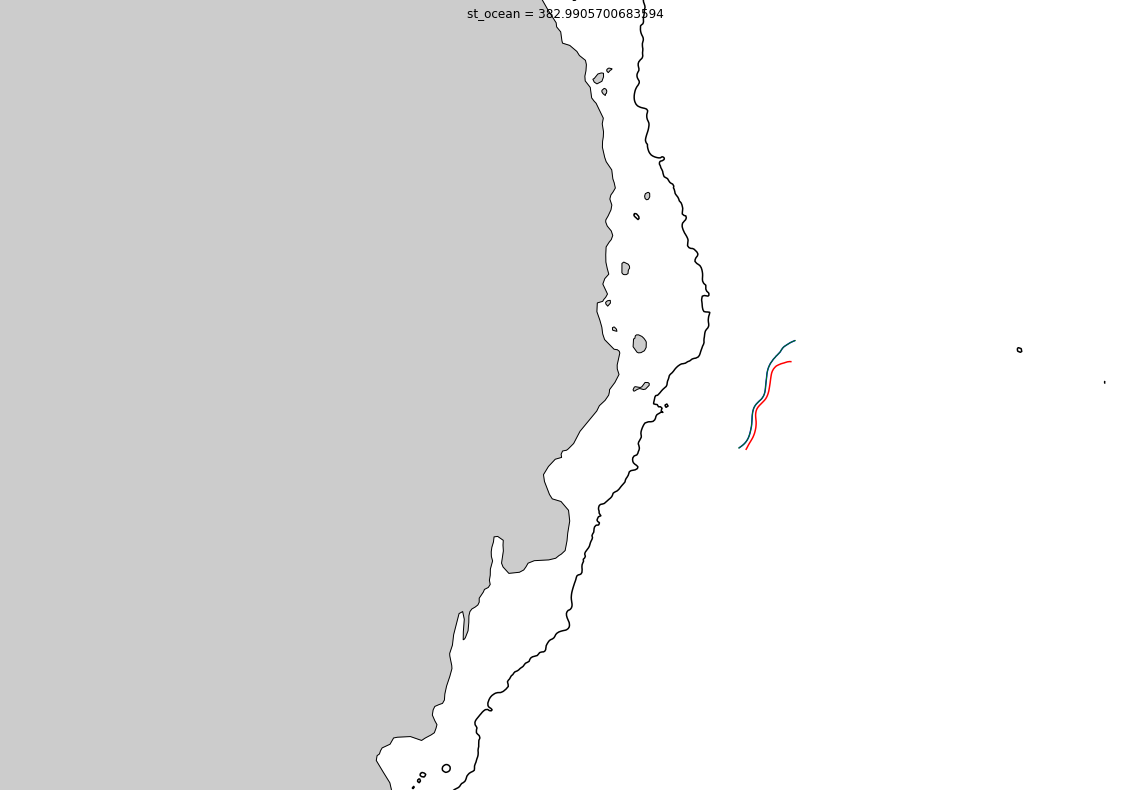

In [27]:
#mb_mask = ht.where(~xr.ufuncs.isfinite(ht.where((ht>1000) & (yt_ocean>-60) & (xt_ocean<-158) & (xt_ocean>-103) )))
pth1b = p1b.collections[0].get_paths()
pth1b.sort(key=len,reverse=True)
v1 = pth1b[0].vertices
x1 = v1[:,0]
y1 = v1[:,1]

#mb_mask = ht.where(~xr.ufuncs.isfinite(ht.where((ht>1000) & (yt_ocean>-60) & (xt_ocean<-158) & (xt_ocean>-103) )))

projection=ccrs.SouthPolarStereo()#EquidistantConic

fig = plt.figure(figsize=(20, 18))
#plt.suptitle('IAF Cycle 1, Big El Nino\'s Temp Anomaly at 200 m')

ax = plt.subplot(1, 1, 1, projection=projection)

ax.set_extent([-275, -245, -80, -55], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# isel(st_ocean=(37))

p3 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=[1000], colors='k',linewidth=1,
#                       x='xt_ocean', y='yt_ocean', levels=2, vmin=999, vmax=1002, colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())
p1a = ltm_temp1.ltm_temp1.sel(st_ocean=(400),method='nearest').sel(yt_ocean=slice(-90,-62)).sel(xt_ocean=slice(-265,-255)).plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=[274.95], colors='r',linewidth=1,
                       transform=ccrs.PlateCarree())

#mb_mask = ht.where(~xr.ufuncs.isfinite(ht.where((ht>1000) & (yt_ocean>-60) & (xt_ocean<-158) & (xt_ocean>-103) )))
p1b = ltm_temp2.ltm_temp2.sel(st_ocean=(400),method='nearest').sel(yt_ocean=slice(-90,-62)).sel(xt_ocean=slice(-265,-255)).plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=[274.95], colors='b',linewidth=1,
                       transform=ccrs.PlateCarree())


ax.plot(x1,y1,'-g',linewidth=1,transform=ccrs.PlateCarree())


In [28]:
expt='01deg_jra55v140_iaf_cycle2'

#warm period on AS shelf
start = '2005-01-01 00:00:00'
end = '2007-12-31 00:00:00'
temp = cc.querying.getvar(expt, variable='temp', 
                       session=session, frequency='1 monthly',ncfile="%monthly-mean%",
                       start_time=start, 
                       end_time=end).sel(yt_ocean=slice(-90,-55)).sel(time=slice(start,end)).mean(dim='time').chunk({'st_ocean':25, 'xt_ocean':1800})
#temp.load()
ltm_temp1=temp.load()
print(ltm_temp1.shape)

ltm_temp1.to_dataset(name='ltm_temp1').to_netcdf('/g/data/v45/pas561/jnb/ensoant/data/temp_01_cycle2_0501to0712.nc')

(75, 584, 3600)


In [29]:
expt='01deg_jra55v140_iaf_cycle2'

#cool period on AS shelf
start = '2015-01-01 00:00:00'
end = '2017-12-31 00:00:00'
temp = cc.querying.getvar(expt, variable='temp', 
                       session=session, frequency='1 monthly',ncfile="%monthly-mean%",
                       start_time=start, 
                       end_time=end).sel(yt_ocean=slice(-90,-55)).sel(time=slice(start,end)).mean(dim='time').chunk({'st_ocean':25, 'xt_ocean':1800})
#temp.load()
ltm_temp2=temp.load()
print(ltm_temp2.shape)

ltm_temp2.to_dataset(name='ltm_temp2').to_netcdf('/g/data/v45/pas561/jnb/ensoant/data/temp_01_cycle2_1501to1712.nc')

(75, 584, 3600)


In [33]:
#tmp=ltm_temp1.sel(st_ocean=400)
#tmp

ltm_temp1

<xarray.DataArray 'temp' (st_ocean: 75, yt_ocean: 584, xt_ocean: 3600)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [273.8093 , 273.8395 , 273.8709 , ..., 273.67334, 273.7243 ,
         273.77463],
        [273.82477, 273.8524 , 273.87805, ..., 273.7057 , 273.7568 ,
         273.7964 ],
        [273.84238, 273.86948, 273.89114, ..., 273.73978, 273.7846 ,
         273.81403]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -55.12 -55.07 -55.01
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03

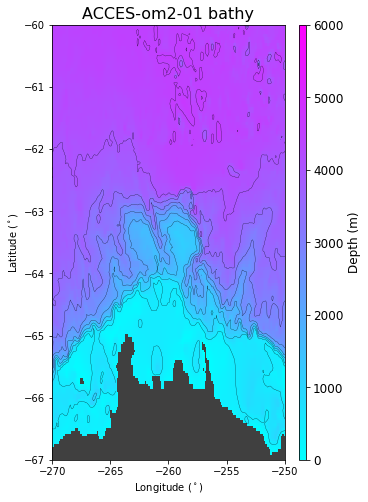

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [38]:
clev = np.arange(0,6000,10)
clev2 = np.arange(0,6000,500)
fontsize=12

plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.gca().patch.set_color('.25')
p1=plt.pcolormesh(ht.xt_ocean,ht.yt_ocean,ht,vmin=0, vmax=6000,cmap=plt.cm.cool)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=clev2,colors='k',linewidths=0.25)
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.ylim([-67,-60])
plt.xlim([-270,-250])
plt.title('ACCES-om2-01 bathy',fontsize = 16)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Depth (m)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

01deg_jra55v140_iaf_cycle2
(60, 490, 100)
(5, 490, 100)
(60, 490, 100)
(5, 490, 100)
(60, 490, 100)
(5, 490, 100)
(60, 490, 100)
(5, 490, 100)
(60, 490, 100)
(5, 490, 100)
(60, 490, 100)
(5, 490, 100)
(60, 490, 100)
(5, 490, 100)
(60, 490, 100)
(5, 490, 100)
(60, 490, 100)
(5, 490, 100)
(60, 490, 100)
(5, 490, 100)
(60, 490, 100)
(5, 490, 100)
(60, 490, 100)
(5, 490, 100)
(12, 490, 100)
(1, 490, 100)
../data/01deg_jra55v140_iaf_cycle2_AS1.8Clines_83w.pkl
01deg_jra55v140_iaf_cycle3
(60, 490, 100)
(5, 490, 100)
(60, 490, 100)
(5, 490, 100)
(60, 490, 100)
(5, 490, 100)
(60, 490, 100)
(5, 490, 100)
(60, 490, 100)
(5, 490, 100)
(60, 490, 100)
(5, 490, 100)
(60, 490, 100)
(5, 490, 100)
(60, 490, 100)
(5, 490, 100)
(60, 490, 100)
(5, 490, 100)
(60, 490, 100)
(5, 490, 100)
(60, 490, 100)
(5, 490, 100)
(60, 490, 100)
(5, 490, 100)
(12, 490, 100)
(1, 490, 100)
../data/01deg_jra55v140_iaf_cycle3_AS1.8Clines_83w.pkl


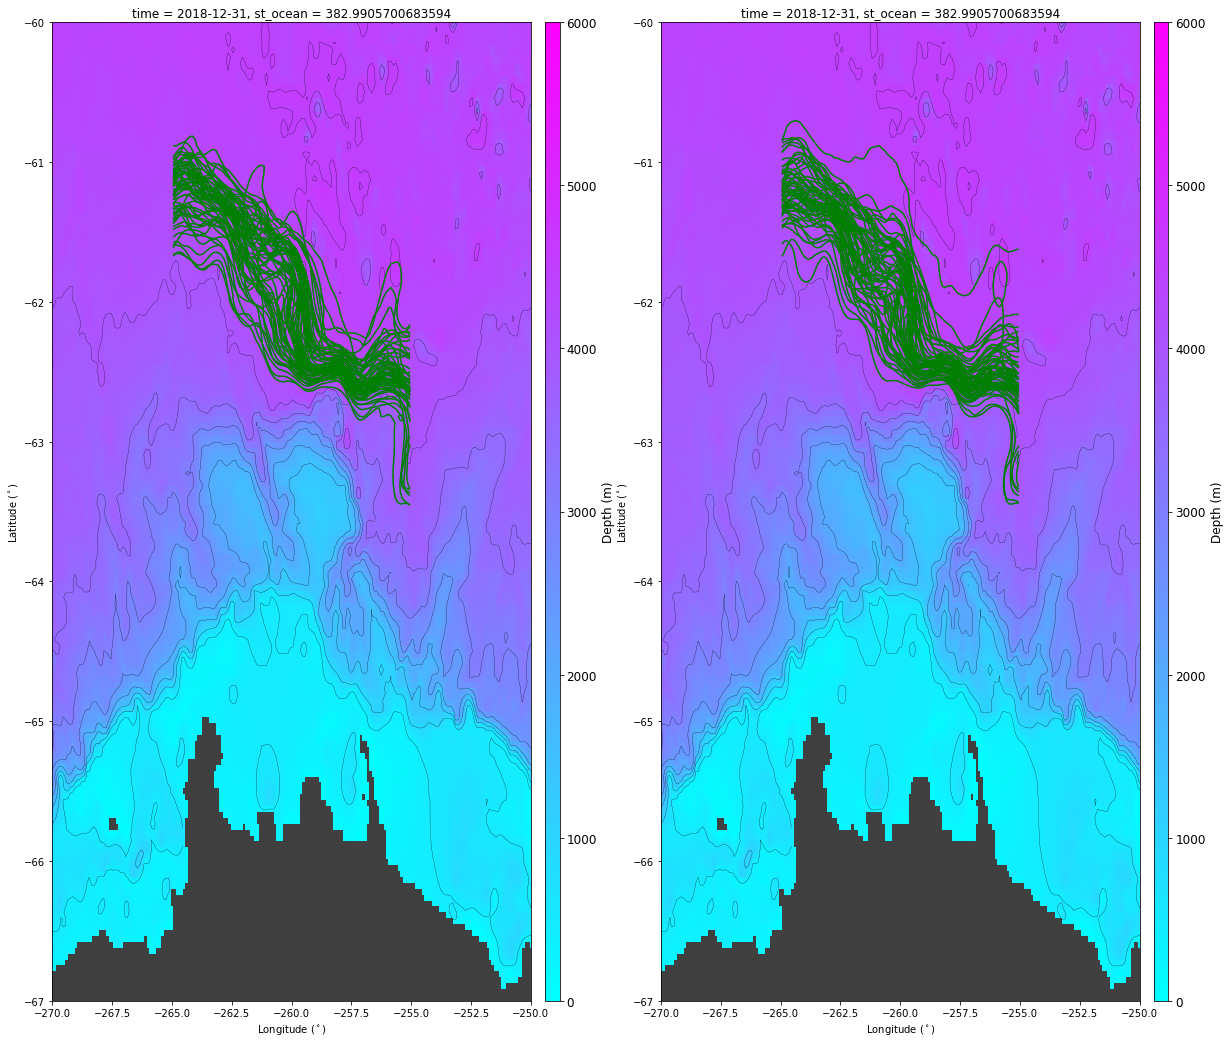

In [42]:
start = '1958-01-01 00:00:00'
end = '2019-01-01 00:00:00'

expts=['01deg_jra55v140_iaf_cycle2', '01deg_jra55v140_iaf_cycle3']

fig = plt.figure(figsize=(20, 18))

cnt=0
for i in expts:
    cnt=cnt+1
    print(i)
    ds = cc.querying.getvar(i, variable='temp', 
                       session=session, frequency='1 monthly',
                       start_time=start, 
                       end_time=end)
    
    all = []
    
    ax = plt.subplot(1, 2, cnt)
    plt.gca().patch.set_color('.25')
    p2=plt.pcolormesh(ht.xt_ocean,ht.yt_ocean,ht,vmin=0, vmax=6000,cmap=plt.cm.cool)
    plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=clev2,colors='k',linewidths=0.25)
    
    #cycle thru time chunks 
    for ii, ds_dec in ds.resample({'time':'5YS'}):
        #print(i,ds_dec)
        t=ds_dec.sel(time=slice(start,end)).sel(st_ocean=(400),method='nearest').sel(yt_ocean=slice(-90,-60)).sel(xt_ocean=slice(-265,-255))#-103
        print(t.shape)
        
        #t = t.resample({'time':'QS-Mar'}).mean('time')
        t = t.resample({'time':'Y'}).mean('time')
        print(t.shape)
        
        for iii in t:
            p1=iii.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=[274.95], colors='g',linewidth=1)
                        #ht.xt_ocean,ht.yt_ocean,ht,levels=clev2,colors='k',linewidths=0.25)

            
            pth1 = p1.collections[0].get_paths()
            pth1.sort(key=len,reverse=True)
            v1 = pth1[0].vertices
            x1 = v1[:,0]
            y1 = v1[:,1]

            all.append(v1)
        
    plt.xlabel('Longitude ($^\circ$)')
    plt.ylabel('Latitude ($^\circ$)')
    plt.ylim([-67,-60])
    plt.xlim([-270,-250])
    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.2)
    cbar = plt.colorbar(p2, cax=cax,orientation = 'vertical',extend = 'neither')
    cbar.set_label(r'Depth (m)',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)
    
    fo='../data/'+str(i)+'_AS1.8Clines.pkl'
    print(fo)
    
    with open(fo, 'wb') as f:
        pickle.dump(all, f)
    

In [46]:
with open('../data/01deg_jra55v140_iaf_cycle2_AS1.8Clines.pkl', 'rb') as file:    
    # Call load method to deserialze
    all = pickle.load(file)
  
print(len(all))

61


61


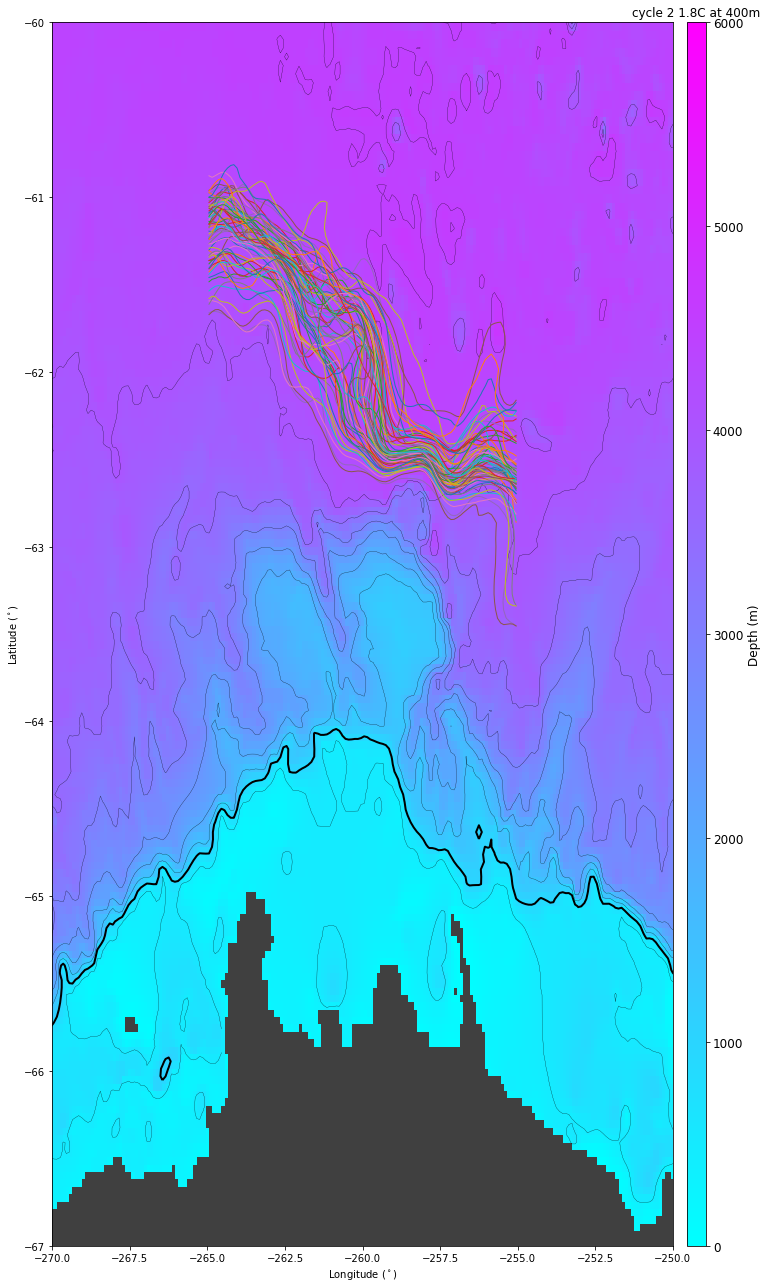

In [49]:
with open('../data/01deg_jra55v140_iaf_cycle2_AS1.8Clines.pkl', 'rb') as file:    
    # Call load method to deserialze
    all = pickle.load(file)
  
print(len(all))
#print(all[0][:,1])

fig = plt.figure(figsize=(20, 18))

ax = plt.subplot(1, 2, 1)
plt.gca().patch.set_color('.25')
p2=plt.pcolormesh(ht.xt_ocean,ht.yt_ocean,ht,vmin=0, vmax=6000,cmap=plt.cm.cool)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=clev2,colors='k',linewidths=0.25)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=2)

yr=1957
for a in all:
    yr+=1
    all[0][:,1]
    ax.plot(a[:,0],a[:,1],'-',linewidth=1,label=yr)

plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.ylim([-67,-60])
plt.xlim([-270,-250])
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p2, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Depth (m)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
plt.title('cycle 2 1.8C at 400m')
plt.tight_layout()



61


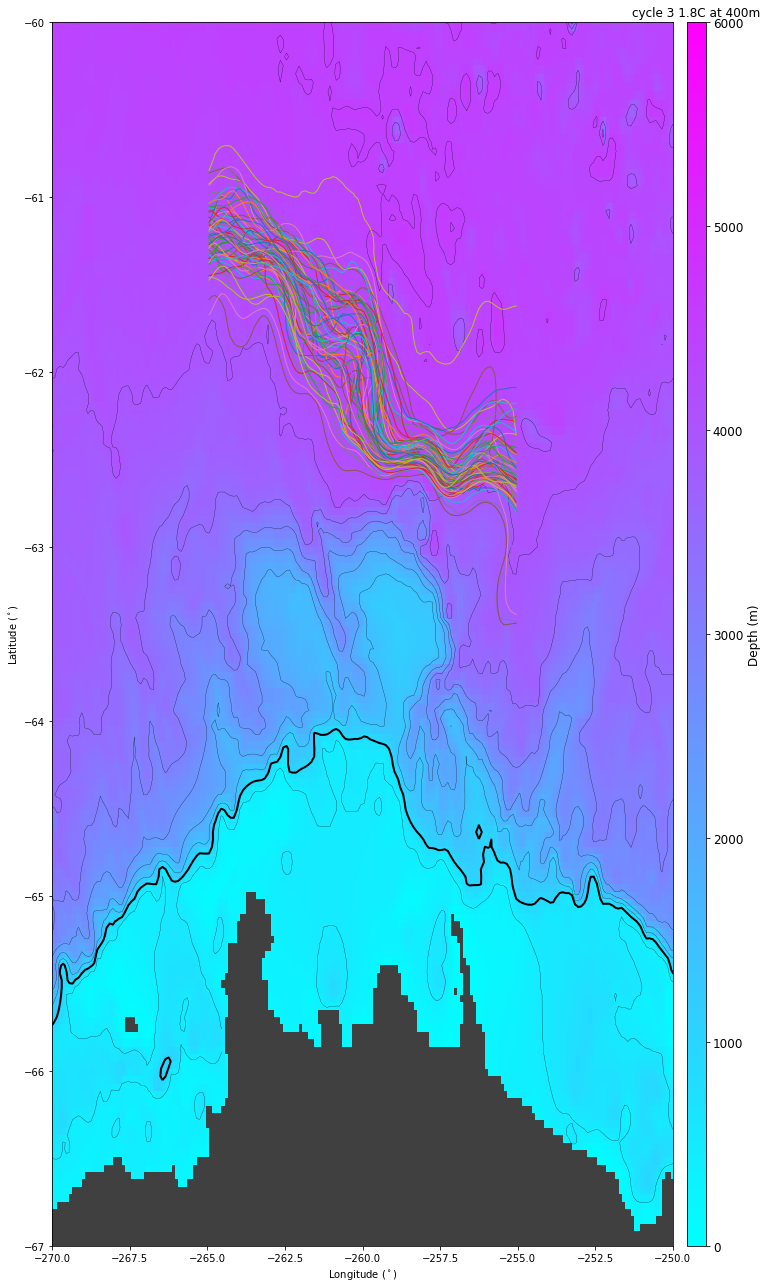

In [50]:
with open('../data/01deg_jra55v140_iaf_cycle3_AS1.8Clines.pkl', 'rb') as file:    
    # Call load method to deserialze
    all = pickle.load(file)
  
print(len(all))
#print(all[0][:,1])

fig = plt.figure(figsize=(20, 18))

ax = plt.subplot(1, 2, 1)
plt.gca().patch.set_color('.25')
p2=plt.pcolormesh(ht.xt_ocean,ht.yt_ocean,ht,vmin=0, vmax=6000,cmap=plt.cm.cool)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=clev2,colors='k',linewidths=0.25)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=2)

yr=1957
for a in all:
    yr+=1
    all[0][:,1]
    ax.plot(a[:,0],a[:,1],'-',linewidth=1,label=yr)

plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.ylim([-67,-60])
plt.xlim([-270,-250])
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p2, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Depth (m)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
plt.title('cycle 3 1.8C at 400m')
plt.tight_layout()



In [51]:
all[0]

array([[-264.95      ,  -61.3305244 ],
       [-264.88018797,  -61.31976922],
       [-264.85      ,  -61.31476049],
       [-264.75      ,  -61.29729402],
       [-264.65      ,  -61.27923751],
       [-264.59519337,  -61.27174031],
       [-264.55      ,  -61.26615512],
       [-264.45      ,  -61.26138665],
       [-264.35      ,  -61.2567224 ],
       [-264.25      ,  -61.24742558],
       [-264.15      ,  -61.2390956 ],
       [-264.05      ,  -61.24680784],
       [-263.95      ,  -61.26448319],
       [-263.85      ,  -61.26791949],
       [-263.81138298,  -61.27174031],
       [-263.75      ,  -61.27780436],
       [-263.65      ,  -61.29264876],
       [-263.55      ,  -61.31192565],
       [-263.49579104,  -61.31976922],
       [-263.45      ,  -61.32660596],
       [-263.35      ,  -61.33643761],
       [-263.25      ,  -61.34559203],
       [-263.15      ,  -61.3534721 ],
       [-263.05      ,  -61.35901065],
       [-262.95      ,  -61.36655023],
       [-262.93041096,  -

In [52]:
aa=np.full((61,2),np.nan)

with open('../data/01deg_jra55v140_iaf_cycle2_AS1.8Clines.pkl', 'rb') as file:    
    # Call load method to deserialze
    all = pickle.load(file)
  
print(len(all))

cnt=-1
for a in all:
    cnt+=1
    aa[cnt,0]=np.mean(a[:,1])
    #print(np.mean(a[:,1]))

with open('../data/01deg_jra55v140_iaf_cycle3_AS1.8Clines.pkl', 'rb') as file:    
    # Call load method to deserialze
    all = pickle.load(file)
  
print(len(all))

cnt=-1
for a in all:
    cnt+=1
    aa[cnt,1]=np.mean(a[:,1])
    #print(np.mean(a[:,1]))

print(aa.shape)

61
61
(61, 2)


In [55]:
np.save('../data/01iafAS1.8Clines',aa)

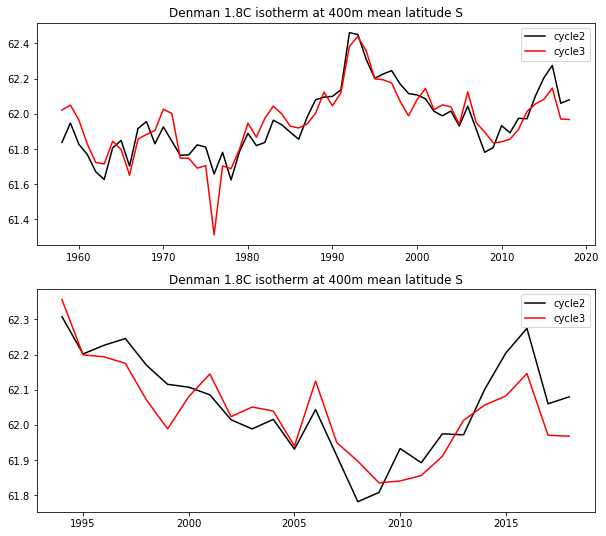

In [56]:
aa=np.load('../data/01iafAS1.8Clines.npy')
yrs=np.arange(1958,2019)
  
fig = plt.figure(figsize=(10, 9))
ax1=plt.subplot(211)
#aa=np.nans(61,1)
ax1.plot(yrs[:],-aa[:,0],linestyle='-',color='k',label='cycle2',linewidth=1.5)
ax1.plot(yrs[:],-aa[:,1],linestyle='-',color='r',label='cycle3',linewidth=1.5)

#ax1.plot(yrs[36:],np.zeros((24,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.75,.75))
#ax1.tick_params('y', colors='b')
plt.title('Denman 1.8C isotherm at 400m mean latitude S')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)

myr=36
ax1=plt.subplot(212)
#aa=np.nans(61,1)
ax1.plot(yrs[myr:],-aa[myr:,0],linestyle='-',color='k',label='cycle2',linewidth=1.5)
ax1.plot(yrs[myr:],-aa[myr:,1],linestyle='-',color='r',label='cycle3',linewidth=1.5)

#ax1.plot(yrs[36:],np.zeros((24,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.75,.75))
#ax1.tick_params('y', colors='b')
plt.title('Denman 1.8C isotherm at 400m mean latitude S')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)

